In [1]:
using LinearAlgebra, Random, Statistics, Plots, SparseArrays
include("proxgrad.jl")

proxgrad_const

In [2]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# OLS is invariant

In [3]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [4]:
w = X\y
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = Xscale\yscale
@show Xscale*wscale / 5;

@show rel_err = norm(X*w - Xscale*wscale/5) / norm(X*w)

X * w = [1.4259713143949548, -1.8137367474987478, 0.266895982970349, 1.7319274070333015, 1.1062106571716939, -0.3767053970312021, -0.47451381031841644, -0.5149573581334528, 0.3269026090944318, 0.5884161754250464, -1.7102607573638804, 2.3101657987364055, -1.1961961635693024, 2.0950663007603767, 1.7323216367816354, 0.7297773381235664, -2.1471727198415405, -1.282142570248881, -0.4716463899474703, -0.3271328824566988]
(Xscale * wscale) / 5 = [1.425971314394955, -1.8137367474987471, 0.2668959829703488, 1.7319274070333006, 1.1062106571716934, -0.37670539703120176, -0.4745138103184165, -0.5149573581334532, 0.32690260909443153, 0.5884161754250463, -1.7102607573638795, 2.3101657987364055, -1.1961961635693017, 2.095066300760376, 1.7323216367816348, 0.7297773381235665, -2.1471727198415396, -1.282142570248881, -0.4716463899474702, -0.32713288245669797]
rel_err = norm(X * w - (Xscale * wscale) / 5) / norm(X * w) = 4.111861481540776e-16


4.111861481540776e-16

# ridge regression is not scaling invariant

In [5]:
size(X'*X + I)

(10, 10)

In [6]:
w = (X'*X + I) \ (X'*y)
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = (Xscale'*Xscale + I) \ (Xscale'*yscale)
@show Xscale * wscale / 5;

@show rel_err = norm(X*w - Xscale*wscale/5) / norm(X*w)

X * w = [1.249265763235169, -1.4521048205583589, 0.2924465531849686, 1.5856834365255377, 0.969762098159815, -0.4025924587627043, -0.4222315124812254, -0.5768848733878487, 0.2896566466774404, 0.48265648740061917, -1.4634999127599186, 2.253267377128271, -1.1807895264377288, 1.8650243357685043, 1.600670133613198, 0.6973219689019157, -1.960276956038553, -1.240730457695908, -0.45181211369959984, -0.2782901464653593]
(Xscale * wscale) / 5 = [1.4033718924777414, -1.764371633152465, 0.2709407952828673, 1.713312338564407, 1.0880394255895511, -0.38112648521941284, -0.4681536580277051, -0.5252551722099019, 0.321708470287798, 0.574039006872973, -1.6775021662182266, 2.3066459309535516, -1.1948877419636053, 2.0656848235162477, 1.716095593585506, 0.7270327524417464, -2.123244334447199, -1.278360712145804, -0.46931114607669294, -0.32010503969076237]
rel_err = norm(X * w - (Xscale * wscale) / 5) / norm(X * w) = 0.10169657759991885


0.10169657759991885

In [7]:
# standardize
function standardize(X,y)
    X_standard = - mean(X,dims=1) .+ X
    X_standard = X_standard * diagm(1 ./ vec(std(X,dims=1)))
    
    y_standard = - mean(y) .+ y
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

Xs, ys = standardize(X,y)
w = (Xs'*Xs + I) \ (Xs'*ys)
@show Xs*w

yscale = 5*y .+ 3000
Xscale = 3*X .+ 200

Xss, yss = standardize(Xscale,yscale)
wscale = (Xss'*Xss + I) \ (Xss'*yss)
@show Xss*wscale;

@show rel_err = norm(Xs*w -  Xss*wscale) / norm(Xs*w)

Xs * w = [0.8569475748300547, -1.128641707268202, 0.12467823888011947, 1.1182237259498011, 0.6680601286450859, -0.36475175493551276, -0.3913026101818799, -0.5129005281334801, 0.16223841594237265, 0.26830414678477377, -1.1642642550065232, 1.6018689728254756, -0.9401636420172839, 1.3207943705432998, 1.1221902992114359, 0.4393499095206681, -1.5345011308862855, -0.9881140345809267, -0.3849385706791679, -0.27307754944382384]
Xss * wscale = [0.856947574830051, -1.1286417072681947, 0.12467823888012797, 1.1182237259497998, 0.668060128645094, -0.36475175493552264, -0.39130261018187507, -0.5129005281334647, 0.1622384159423571, 0.26830414678477554, -1.164264255006529, 1.6018689728254718, -0.9401636420172748, 1.3207943705433012, 1.122190299211442, 0.43934990952068875, -1.5345011308862944, -0.9881140345809277, -0.384938570679151, -0.27307754944382706]
rel_err = norm(Xs * w - Xss * wscale) / norm(Xs * w) = 1.0586827001001874e-14


1.0586827001001874e-14

# let's compare different kinds of regularized regression

In [8]:
function ridge_regression(X,y; λ=1)
    proxgrad(1/n*QuadLoss(), QuadReg(λ), X, y, maxiters=1000)
end

ridge_regression (generic function with 1 method)

In [9]:
function lasso(X,y; λ=1)
    proxgrad(1/n*QuadLoss(), OneReg(λ), X, y, maxiters=1000)
end

lasso (generic function with 1 method)

In [10]:
function nnls(X,y)
    proxgrad(1/n*QuadLoss(), NonNegConstraint(), X, y, maxiters=1000)
end

nnls (generic function with 1 method)

In [11]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

In [12]:
w_sparse

30-element SparseVector{Float64,Int64} with 18 stored entries:
  [2 ]  =  -1.70591
  [3 ]  =  -1.87305
  [4 ]  =  -0.268076
  [5 ]  =  -0.973682
  [6 ]  =  0.0276625
  [7 ]  =  -0.622028
  [8 ]  =  0.267128
  [10]  =  1.35722
  [11]  =  -0.00064617
  [13]  =  -0.850061
  [14]  =  -1.03386
  [16]  =  -0.664553
  [18]  =  0.360191
  [19]  =  -1.36397
  [22]  =  0.474194
  [23]  =  -1.24382
  [24]  =  -0.548475
  [30]  =  0.474971

In [13]:
# find best model for each type of data
w = w_sparse

λridge=.1
λlasso=.1

X,y = generate_data(30, w)
w_ridge = ridge_regression(X,y; λ=λridge)
w_lasso = lasso(X,y; λ=λlasso)
w_nonneg = nnls(X,y);

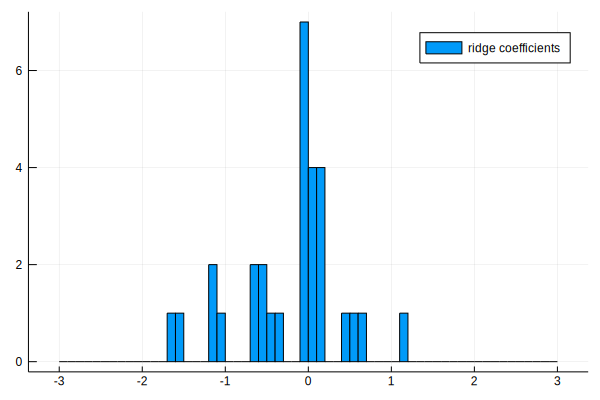

In [14]:
histogram(w_ridge, label="ridge coefficients", bins=-3:.1:3)

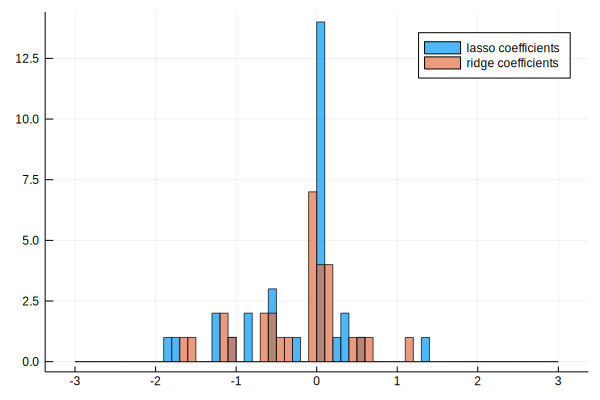

In [15]:
histogram(w_lasso, label="lasso coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

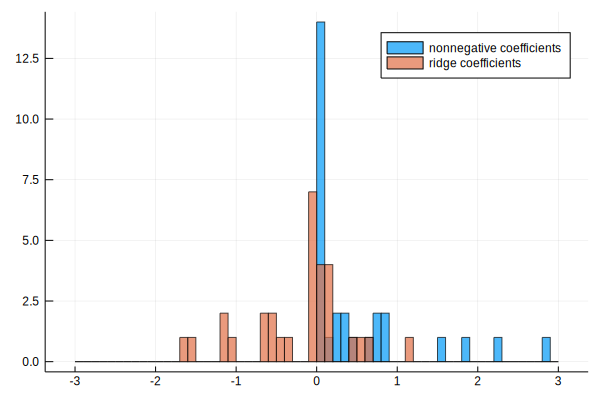

In [16]:
histogram(w_nonneg, label="nonnegative coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

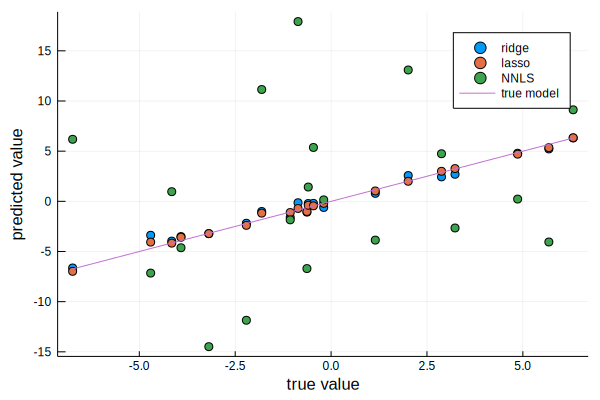

In [17]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

scatter(ytest,Xtest*w_ridge,label="ridge")
scatter!(ytest,Xtest*w_lasso,label="lasso")
scatter!(ytest,Xtest*w_nonneg,label="NNLS")
plot!(ytest,ytest,label="true model")
xlabel!("true value")
ylabel!("predicted value")

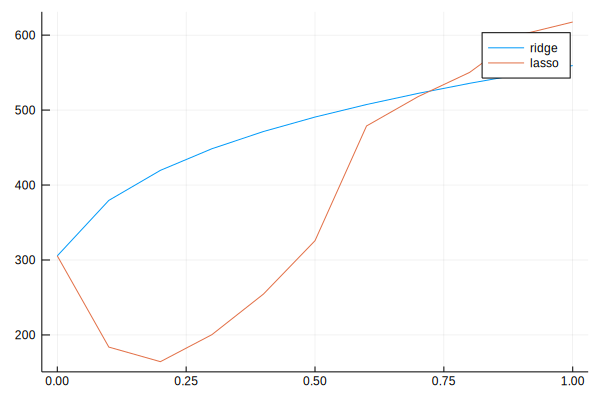

In [18]:
# cross validate over lambda
Random.seed!(1)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = Float64[]
lasso_error = Float64[]
λs = 0:.1:1
for λ in λs
    w = ridge_regression(X,y; λ=λ)
    push!(ridge_error, sum((ytest - Xtest*w).^2))
    w = lasso(X,y; λ=λ)
    push!(lasso_error, sum((ytest - Xtest*w).^2))
end
plot(λs, ridge_error, label="ridge")
plot!(λs, lasso_error, label="lasso")